# A. Creating Spark Session and Loading the Data

## Step 01: Import Spark Session and initialize Spark

Spark context has been imported and Spark session has been created in order to used the SQL API's, HIVE andd etc
Thes created Spark session uses 4 local cores and appname() to name the application

Importing all the nessesary packages needed for the application

In [1]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.mongodb.spark:mongo-spark-connector_2.11:2.4.0 pyspark-shell'
from pyspark import SparkContext 
from pyspark.sql import SparkSession

sc = SparkContext.getOrCreate()

if (sc is None):
    sc = SparkContext(master="local[4]")
spark = SparkSession(sparkContext=sc)\
        .builder\
        .appName("Weather Prediction App")\
        .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.11:2.4.0")\
        .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/fit5202_db.AUSweather_collection")\
        .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/fit5202_db.AUSweather_collection")\
        .getOrCreate()

from pyspark.sql.types import DoubleType
from pyspark.ml.feature import Imputer
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, GBTClassifier, RandomForestClassifier
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Step 02: Load the dataset and print the schema and total number of entires in the file

spark.read.csv has been used to read the given CSV file and the number of entirs in the file has been printed along with the schema of the dataframe created by importing the CSV file.

In [2]:
df = spark.read.csv("weatherAUS.csv", inferSchema=True, header = True)
df.show(5, truncate = False)
print("Number of Records in the document", df.count())
df.printSchema()

+-------------------+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|Date               |Location|MinTemp|MaxTemp|Rainfall|Evaporation|Sunshine|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|Cloud9am|Cloud3pm|Temp9am|Temp3pm|RainToday|RainTomorrow|
+-------------------+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|2008-12-01 00:00:00|Albury  |13.4   |22.9   |0.6     |NA         |NA      |W          |44           |W         |WNW       |20          |24          |71         |22         |1007.7     |1007.1     |8       |NA      |16.9   |21.8   |

# B. Data Cleaning and Processing

## Step 03: Delete columns from the dataset

The mentioned columns have been dropped to maintain the data quality and in the end the accuracy of our ML models.

In [3]:
RainPredictionDF = df.drop('Date','Location','Evaporation','Sunshine','Cloud9am','Cloud3pm','Temp9am','Temp3pm')
RainPredictionDF.show(50, truncate = True)

+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|   13.4|   22.9|     0.6|          W|           44|         W|       WNW|          20|          24|         71|         22|     1007.7|     1007.1|       No|          No|
|    7.4|   25.1|       0|        WNW|           44|       NNW|       WSW|           4|          22|         44|         25|     1010.6|     1007.8|       No|          No|
|   12.9|   25.7|       0|        WSW|           46|         W|       WSW|          19|          26|         38|         30|     1007.6|    

Printing Schema after dropping the unnessesary columns

In [4]:
RainPredictionDF.printSchema()

root
 |-- MinTemp: string (nullable = true)
 |-- MaxTemp: string (nullable = true)
 |-- Rainfall: string (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: string (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: string (nullable = true)
 |-- WindSpeed3pm: string (nullable = true)
 |-- Humidity9am: string (nullable = true)
 |-- Humidity3pm: string (nullable = true)
 |-- Pressure9am: string (nullable = true)
 |-- Pressure3pm: string (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)



## Step 04: Print the number of missing data in each column

The number of NA(Null) values in the each of the columns have been displayed.

In [5]:
from pyspark.sql.functions import isnan, when, count, col
RainPredictionDF.select([count(when(RainPredictionDF[c] == 'NA', c)).alias(c) for c in RainPredictionDF.columns]).show()

+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|    637|    322|    1406|       9330|         9270|     10013|      3778|        1348|        2630|       1774|       3610|      14014|      13981|     1406|           0|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+



Converted all the NA values to Null so that Replacement can be done easily in the next step.

In [6]:
def naToNull(df_column):
    return when(col(df_column) != "NA", col(df_column)).otherwise(None)
        
to_convert = RainPredictionDF.columns

exprs = [naToNull(x).alias(x) if x in to_convert else x for x in RainPredictionDF.columns]
new_df = RainPredictionDF.select(*exprs)
new_df.show(20)

+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|   13.4|   22.9|     0.6|          W|           44|         W|       WNW|          20|          24|         71|         22|     1007.7|     1007.1|       No|          No|
|    7.4|   25.1|       0|        WNW|           44|       NNW|       WSW|           4|          22|         44|         25|     1010.6|     1007.8|       No|          No|
|   12.9|   25.7|       0|        WSW|           46|         W|       WSW|          19|          26|         38|         30|     1007.6|    

## Step 06 - Part 1 - Converted numerical columns to double type

This part was supposed to done after step 05 that is after replacing mena and mode values where ever nessesary. But I have preffered to do it here as it is better to deal with the numerical coulumn once the type has been converted.
(The StringIndexer part of step 06 has been done later.)

In [7]:
Double_type = ["MinTemp","MaxTemp","Rainfall","WindGustSpeed","WindSpeed9am","WindSpeed3pm",
     "Humidity9am","Humidity3pm","Pressure9am","Pressure3pm"]

String_type = ['WindGustDir', 'WindDir9am',  'WindDir3pm', 'RainToday', 'RainTomorrow']

for c in Double_type:
    new_df = new_df.withColumn(c, new_df[c].cast('double'))
    
new_df.printSchema()

root
 |-- MinTemp: double (nullable = true)
 |-- MaxTemp: double (nullable = true)
 |-- Rainfall: double (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: double (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: double (nullable = true)
 |-- WindSpeed3pm: double (nullable = true)
 |-- Humidity9am: double (nullable = true)
 |-- Humidity3pm: double (nullable = true)
 |-- Pressure9am: double (nullable = true)
 |-- Pressure3pm: double (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)



## Step 05 - Fill the missing data with average value and maximum occurrence value.

Here I have use the pyspark's ML feature Imputer to impute the mean values for all the double columns or the numerical columns

In [8]:
imputer = Imputer(
    inputCols=Double_type,
    outputCols=["{}".format(c) for c in Double_type])

DF_mean = imputer.setStrategy("mean").fit(new_df).transform(new_df)

Checking the NA values in each column after replacing mean to check if means have been populated where ever nessesary.

In [9]:
DF_mean.select([count(when(DF_mean[c].isNull()|isnan(c), c))\
                             .alias(c) for c in DF_mean.columns])\
                             .show()

+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|      0|      0|       0|       9330|            0|     10013|      3778|           0|           0|          0|          0|          0|          0|     1406|           0|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+



For Replacing the NA values with the mode values, a function has been written to which computes the mode of each column and store is in a dictionary format along with the column names.

In [10]:
def calMode(df, column):
    df_mode = df.where(col(column).isNotNull())\
    .groupBy(column)\
    .count()
    
    return df_mode.sort(col("count").desc()).collect()[0][0]

mode_dict = {column: calMode(DF_mean, column) for column in String_type}
mode_dict

{'WindGustDir': 'W',
 'WindDir9am': 'N',
 'WindDir3pm': 'SE',
 'RainToday': 'No',
 'RainTomorrow': 'No'}

The same disctionary is used to fill the mode values in the repective columns where nessesary.

In [11]:
df_mode = DF_mean.na.fill(mode_dict)    
df_mode.select([count(when(df_mode[c].isNull()|isnan(c), c)).alias(c) for c in df_mode.columns]).show()
df_mode.printSchema()

+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|      0|      0|       0|          0|            0|         0|         0|           0|           0|          0|          0|          0|          0|        0|           0|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+

root
 |-- MinTemp: double (nullable = true)
 |-- MaxTemp: double (nullable = true)
 |-- Rainfall: double (nullable = true)
 |-- WindGustDir

## Step 06 - Data tranformation

The StringIndexer is used to convert the non-numerical columns into numerical columns

## Step 07 - Create the feature Vector and Divide the data set

In the same step the step 07 has also been performed as the data is put into a pipeline with a series of transformations to ultimately get the data in the for of features to apply the ML algorithms on.

Since the data is put in a pipeline the step 06 was also performed in the same step and the stringindexer was also added to the pipeline.

Please read the comments to know where the step has been performed 

In [12]:
categoricalColumns = ['WindGustDir', 'WindDir9am',  'WindDir3pm', 'RainToday']
numericCols = Double_type

stages = []

for column in categoricalColumns:  
    indexers = StringIndexer(inputCol=column, outputCol='{}_Index'.format(column)) ## String Indexer STEP 06
    encoder = OneHotEncoderEstimator(inputCols=[indexers.getOutputCol()], outputCols=[column + "classVec"])##OneHot STEP 07
    stages += [indexers, encoder] 
    
label_stringIdx = StringIndexer(inputCol = 'RainTomorrow', outputCol = 'label')## StringIndexer STEP 06

stages += [label_stringIdx]

assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols = assemblerInputs, outputCol="features")## Vector Assembler STEP 07

stages += [assembler]

pipeline = Pipeline(stages=stages)
modelPipeline = pipeline.fit(df_mode)
df = modelPipeline.transform(df_mode)

The Data set has been randomly split and divided into training and test set with a ratio of 70:30 respectively

In [13]:
train, test = df.randomSplit([0.7, 0.3], seed = 42)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 99612
Test Dataset Count: 42581


# C. Apply Machine Learning Algorithms

## Step 08: Apply Machine Learning classification algorithms on the dataset and compare their accuracy. Plot the accuracy as a abar graph.

The model taken under consideration were
1. Logistic Regeression
2. Desicion Tree Classifier
3. Random Forest Classifier
4. GBT Classifier 

The accuracy of each of the classification algorithms are calculated with the intension to predict the probability of NO RAIN TOMMOROW (0) (that being the true positive in my cinfusion matrix)

### Logistic Regression Model

In [14]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label',    maxIter=10)
lrModel = lr.fit(train)

lrpredictions = lrModel.transform(test)

In [15]:
lrmetrics = MulticlassMetrics(lrpredictions.select("prediction", "label").rdd)
lrAcc = lrmetrics.accuracy*100
print("Logistic Regression Accuracy: " + str(lrAcc)+"%")

Logistic Regression Accuracy: 81.74537939456566%


### Decision Tree Classifier Model

In [16]:
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxDepth = 3)
dtmodel = dt.fit(train)

dtpredictions = dtmodel.transform(test)

In [17]:
dtmetrics = MulticlassMetrics(dtpredictions.select("prediction", "label").rdd)
dtAcc = dtmetrics.accuracy*100
print("Decision Tree Classifier Accuracy: " + str(dtAcc)+"%")

Decision Tree Classifier Accuracy: 82.38651041544351%


### Random Forest Classifier Model

In [18]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)
rfmodel = rf.fit(train)

rfpredictions = rfmodel.transform(test)

In [19]:
rfmetrics = MulticlassMetrics(rfpredictions.select("prediction", "label").rdd)
rfAcc = rfmetrics.accuracy*100
print("Random Forest Classifier Accuracy: " + str(rfAcc)+"%")

Random Forest Classifier Accuracy: 82.68006857518611%


### GBT Classifier Model

In [20]:
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)
gbtmodel = gbt.fit(train)

gbtpredictions = gbtmodel.transform(test)

In [21]:
gbtmetrics = MulticlassMetrics(gbtpredictions.select("prediction", "label").rdd)
gbtAcc = gbtmetrics.accuracy*100
print("GBT Classifier Accuracy: " + str(gbtAcc)+"%")

GBT Classifier Accuracy: 83.91770977666096%


## Plotting the accuracy of each of the models using a bar chart 

In [22]:
ListAcc = [lrAcc, dtAcc, rfAcc, gbtAcc]
ListNames = ["Logistic Regression", "Decision Tree Classifier","Random Forest Classifier","GBT Classifier"]

def plot_acc(Acc, Names):
    objects_y_1 = Acc
    objects_x_1 = Names
    y_pos_1 = np.arange(len(objects_y_1))
    x_pos_1 = np.arange(len(objects_x_1)) 
    y_axis_1 = Acc
    x_axis_1 = Names
    plt.figure(figsize=(10,5))
    plt.bar(x_axis_1, y_axis_1, align='center', color='darkcyan')
    plt.xticks(x_pos_1, objects_x_1, rotation = 0)
    #plt.yticks(objects_y_1 )
    plt.xlabel('Classifier Models')
    plt.ylabel('Accuracy')
    plt.title('Plotting the Accuracy of each classifier model')
    plt.style.use('seaborn-whitegrid')
    for i, v in enumerate(y_axis_1):
        plt.text(y_pos_1[i] - 0.3, v , str(v))
    plt.show()

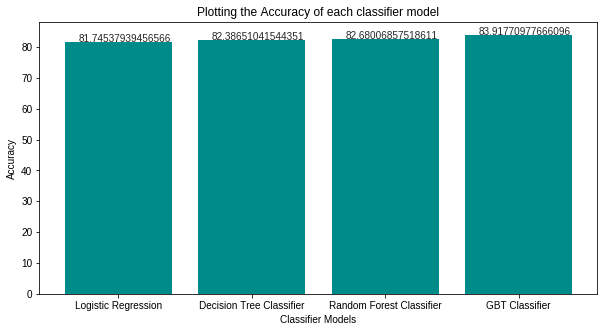

In [23]:
plot_acc(ListAcc, ListNames)

## Step 09 : Calculate confusion Matrix and find precision, recall and F1 score of each classification algorithm. Explain how the accuracy can be improved

The precision, recall and the F1 score of each of the classification algorithms are calculated with the intension to predict the probability of NO RAIN TOMMOROW (0) (that being the true positive in my cinfusion matrix)

### Calculating the confusion matrix for logostic regression model and calculating the precision, recall and f1 score for the same

In [24]:
lrmetrics.confusionMatrix().toArray()

array([[30838.,  2183.],
       [ 5590.,  3970.]])

In [25]:
lrprecision = lrmetrics.precision(0.0)
print("Logistic Regression Precision: " + str(lrprecision))

Logistic Regression Precision: 0.8465466124958823


In [26]:
lrrecall = lrmetrics.recall(0.0)
print("Logistic Regression Recall: " + str(lrrecall))

Logistic Regression Recall: 0.933890554495624


In [27]:
lrf1score = lrmetrics.fMeasure(0.0, 2.0)
print("Logistic Regression F1 score: " + str(lrf1score))

Logistic Regression F1 score: 0.9150090201291304


### Calculating the confusion matrix for decision tree classifier model and calculating the precision, recall and f1 score for the same

In [28]:
dtmetrics.confusionMatrix().toArray()

array([[31597.,  1424.],
       [ 6076.,  3484.]])

In [29]:
dtprecision = dtmetrics.precision(0.0)
print("Decision Tree Classifier Precision: " + str(dtprecision))

Decision Tree Classifier Precision: 0.8387173838027234


In [30]:
dtrecall = dtmetrics.recall(0.0)
print("Decision Tree Classifier Recall: " + str(dtrecall))

Decision Tree Classifier Recall: 0.9568759274401138


In [31]:
dtf1score = dtmetrics.fMeasure(0.0, 2.0)
print("Decision Tree Classifier F1 score: " + str(dtf1score))

Decision Tree Classifier F1 score: 0.930653816926548


### Calculating the confusion matrix for random forest classifier model and calculating the precision, recall and f1 score for the same

In [32]:
rfmetrics.confusionMatrix().toArray()

array([[32196.,   825.],
       [ 6550.,  3010.]])

In [33]:
rfprecision = rfmetrics.precision(0.0)
print("Random forest Classifier Precision: " + str(rfprecision))

Random forest Classifier Precision: 0.8309502916430083


In [34]:
rfrecall = rfmetrics.recall(0.0)
print("Random forest Classifier Recall: " + str(rfrecall))

Random forest Classifier Recall: 0.9750158989733806


In [35]:
rff1score = rfmetrics.fMeasure(0.0, 2.0)
print("Random forest Classifier F1 score: " + str(rff1score))

Random forest Classifier F1 score: 0.9423403383480651


### Calculating the confusion matrix for GBT classifier model and calculating the precision, recall and f1 score for the same

In [36]:
gbtmetrics.confusionMatrix().toArray()

array([[31556.,  1465.],
       [ 5383.,  4177.]])

In [37]:
gbtprecision = gbtmetrics.precision(0.0)
print("GBT Classifier Precision: " + str(gbtprecision))

GBT Classifier Precision: 0.8542732613227212


In [38]:
gbtrecall = gbtmetrics.recall(0.0)
print("GBT Classifier Recall: " + str(gbtrecall))

GBT Classifier Recall: 0.9556342933284879


In [39]:
gbtf1score = gbtmetrics.fMeasure(0.0, 2.0)
print("GBT Classifier F1 score: " + str(gbtf1score))

GBT Classifier F1 score: 0.9334824254687232


### How to increase the accuracy the accuracy of the models??

#### The Accuracy of the model can be invreased in many differernt ways.

##### 1. Feature Selection/Engineering

The features considered for building the models have to be extracted by applying a feature selection method such as AIC or BIC score. This would ensure that the features selected for building the model are apt and would not underfit or overfit the model which affects the accuracy of the prediction.


##### 2. Find the apt model which will suit the application needs

In this case, since the task was binary classification, SVM (Support vector machine) would have been a better model in comaprison to logistic regression


##### 3. ML Tuning

Validating the model by running validation test with different set of test and training data ensures that the accuracy of the model improves. For example Cross validation could be done to refine the accuracy of the model.


##### 4. Maintain Balance in the dataset

A dataset should be balanced, as in the prediction outcome in the test set should be almost equal in number to avoid leaning toward a specific outcome. Another approach to do this would be a appropriate method of sampling the data to avoid chances of the machine learning more about a particular outcome.





#### Cross Validation done on GBT (The one with the best accuracy) to refine the accuracy further

In [40]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()

paramGr = (ParamGridBuilder().addGrid(gbt.maxDepth, [2,4,6])
          .addGrid(gbt.maxBins, [20,60])
          .addGrid(gbt.maxIter, [10,20])
          .build())

cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGr, evaluator=evaluator, numFolds = 5)
cvModel = cv.fit(train)
predictions = cvModel.transform(test)


0.8630978444806081

In [44]:
cvAcc = evaluator.evaluate(predictions)
print("Cross Validation Accuracy of GBT: " + str(cvAcc*100)+"%")

Cross Validation Accuracy of GBT: 86.30978444806058%
